<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar bibliotecas

In [ ]:
!pip install contractions

In [ ]:
import pandas as pd
import numpy as np
import contractions
import re

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

## Descomprimir archivo

In [ ]:
#from zipfile import ZipFile
#with ZipFile('/content/Reviews.csv.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Datos/Amazon reviews')

# Leer datos de entrada

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datos/Amazon reviews/Reviews.csv',
                 nrows=20000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(19326, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 11610
Great made in China product for dogs.
I've noticed that quite a few people don't seem to believe the labels of products made in China, when it is usually a U.S. company that dictates what goes into the product.  Besides read the labels of products made right here--a vast majority of them contain toxic to humans & animals ingredients--everything from paint & varnish to the food is tainted with these toxic chemicals & all made right here in the U.S.A.  So, if you can trust a U.S. label--why not trust a Chinese label?  These treats are sure a hit with our dogs--all 7 of them love the chicken, lamb & rice, & the duck with glucosamine & chrondroitin.  We buy this type because of our older dogs with severe arthritis.  Our 15 yr. old was almost beyond walking until we started feeding him these snacks & our 9 yr. old Chihuahua's hip problems are much improved. On S&S these snacks are the cheapest price that we have found & with free shipping--Keep 'em coming Dogswell & Amazon--

In [ ]:
df.to_csv('Amazon_reviews_trim.csv', index=False)

# Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [ ]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [ ]:
for col in df.columns:
  df[col] = df[col].apply(preprocesar)
  
df.loc[738,'Text']

'i can honestly say this is the worst frosting we have ever bought it is kind of generous to call it frosting it has more the consistency of rubber cement and since we were in a time crunch we did not have the luxury of going back out to the store for a different frosting so we forged ahead and decorated a cake with it horrible experience bad enough to put us off cake decorating forever it spread about as easily as chewing gum stuck to everything it came in contact with and got crumbs of the cake mixed up in it on top of all this it did not even taste good by the time we were done decorating we knew there was no way we could feed this mess to our family so we ended up going to the store anyway to buy a pre made cake our cake which took twice as long to decorate because this stuff is so gooey was used as a centerpiece a really ugly centerpiece that cracked and peeled as the frosting dried '

In [ ]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 17884
tokenstart junk junk junk tokenend
i have not used this in few years but a bought the biggest bag lowes had for around 10 or 12 bucks i planted some seedlings in a hurry no sooner got them potted and realized the mistake i made it is 50 wood chips and pine bark that actually smells like it came from a forest fire there is nothing it it that even looks like soil this is just a friendly note to anyone thinking of using this do not do it this is crap junk the worst i will not call it garbage because decomposed food would be way better i will never buy anything with the miracle gro name on it again 

Review # 10526
tokenstart not treats cat food  tokenend
this may seem like a treat to my cats but it really is food my two youngest cats prefer tasty treasures over all the friskies flavors they sit and and eat until every last bit is gone i have never had a cat do that with any cat food i have been waiting for amazon to carry all the flavors at a reasonable price so i can stop

# Limitar la cantidad de palabras en textos y resumenes

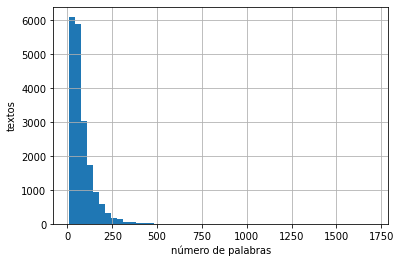


El 90% de los textos tiene 162 palabras


In [ ]:
# ¿Cuantas palabras tienen cada texto?
palabras_textos = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_textos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_textos.quantile(0.90)))

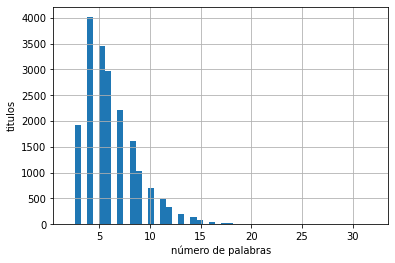


El 97.5% de los titulos tiene 13 palabras


In [ ]:
# ¿Cuantas palabras tienen cada titulo?
palabras_titulos = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_titulos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("titulos")
plt.show()

print('\nEl 97.5% de los titulos tiene {:,.0f} palabras'.format(palabras_titulos.quantile(0.975)))

In [ ]:
longitud_max_textos = palabras_textos.quantile(0.90)     #162 palabras
longitud_max_titulos = palabras_titulos.quantile(0.975)  # 13 palabras

In [ ]:
datos =  df[(palabras_textos <= longitud_max_textos ) | (palabras_titulos <= longitud_max_titulos)]
datos.shape   

(19198, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)

# Vectorización del texto

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.data import Dataset

### Paso 1 Diccionario de vocabulario con clave y vectorizador de textos

In [ ]:
def genera_dic_vocabulario(serie_pd, max_tokens= 20000):
  '''Obtiene el vocabulario de una serie de pandas con textos en forma de 
  diccionario, donde cada palabra es una clave y el valor es un indice'''
  vectorizer = TextVectorization(max_tokens = max_tokens)
  text_ds = Dataset.from_tensor_slices(serie_pd).batch(128)  
  vectorizer.adapt(text_ds)
  voc = vectorizer.get_vocabulary()  # lista con el vocabulario
  #diccionario con el vocabulario
  dic_vocabulario = dict(zip(voc, range(len(voc))))
  return dic_vocabulario, vectorizer

In [ ]:
%%time
vocabulario_dic, vectorizer_reseña = genera_dic_vocabulario(x_train)

CPU times: user 1.08 s, sys: 341 ms, total: 1.42 s
Wall time: 6.43 s


In [ ]:
test = ['got', 'wild', 'hair', 'ordered', 'pound', 'bag']
[vocabulario_dic[w] for w in test]

[155, 1482, 1589, 194, 677, 109]

In [ ]:
vectorizer_reseña(test)

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[ 155],
       [1482],
       [1589],
       [ 194],
       [ 677],
       [ 109]])>

### Paso 2 Diccionario con vectores de palabras (embeddings) [GloVe](https://nlp.stanford.edu/projects/glove/), previamente entrenados


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [ ]:
%%time
dic_embeddings_GloVe  = {}
with open('/content/drive/MyDrive/Datos/Embeddings/glove.6B.100d.txt') as f:
    for line in f:
        palabra, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        dic_embeddings_GloVe [palabra] = coefs

#Cantidad de palabras en glove
len(dic_embeddings_GloVe )

CPU times: user 6.61 s, sys: 283 ms, total: 6.89 s
Wall time: 8.97 s


In [ ]:
print(dic_embeddings_GloVe ["got"].shape)
dic_embeddings_GloVe ["got"]

(100,)


array([ 0.54635  ,  0.19018  ,  0.51298  , -0.76729  , -0.23824  ,
       -0.065802 ,  0.24464  ,  0.32024  , -0.13215  , -0.51083  ,
        0.69103  ,  0.24462  ,  0.075322 ,  0.34058  ,  0.37736  ,
       -0.27647  , -0.22937  ,  0.32059  , -0.43115  ,  0.37238  ,
        0.43887  ,  0.67325  ,  0.1064   , -0.28668  ,  0.16699  ,
        0.0035841, -0.6208   , -0.31726  ,  0.55472  , -0.47293  ,
       -0.072485 ,  1.1329   ,  0.45969  ,  0.59817  ,  0.43119  ,
       -0.11359  , -0.70584  ,  0.37556  ,  0.048478 ,  0.43989  ,
       -0.078231 , -0.3277   ,  0.37055  , -0.86839  , -0.22885  ,
       -0.049179 , -0.21562  , -0.049966 ,  0.82177  , -1.0077   ,
       -0.3538   , -0.12548  , -0.4025   ,  0.70979  , -0.24674  ,
       -2.4466   , -0.099338 ,  0.49705  ,  1.0912   ,  0.73681  ,
        0.26601  ,  1.0726   , -1.1285   ,  0.22433  ,  0.47524  ,
       -0.3435   ,  0.44802  ,  0.3436   , -0.29327  ,  0.34002  ,
       -0.061204 ,  0.12671  ,  0.049335 , -0.33836  ,  0.0145

### Paso 3 Obtener la matriz de vectores para todas las palabras del vocabulario 
embedding_texto()

In [ ]:
def embedding_texto(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    num_tokens = len(dic_vocabulario.keys()) + 2
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [ ]:
embedding_matrix = embedding_texto(vocabulario_dic, dic_embeddings_GloVe , 100)

17344 palabras vectorizadas, que representan 86.7% de todas las palabras en el corpus


In [ ]:
embedding_matrix.shape

(20002, 100)


**Repetiremos el paso 1 y el paso 3 para crear el diccionario de los Resumenes.(el diccionario con vectores GloVe es el mismo)**

In [ ]:
vocabulario_dic_sum, vectorizer_sum = genera_dic_vocabulario(y_train)
embedding_matrix_sum = embedding_texto(vocabulario_dic_sum, dic_embeddings_GloVe , 100)
embedding_matrix_sum.shape

5484 palabras vectorizadas, que representan 87.8% de todas las palabras en el corpus


(6247, 100)

## Paso 4. Vectorizar conjunto de entrenamiento y pruba

In [ ]:
vectorizer_reseña(datos.loc[5,'Text'])

<tf.Tensor: shape=(73,), dtype=int64, numpy=
array([   3,  155,    5, 1482, 1589,   12, 2230,    4,  194,   10,  759,
        677,  109,    2, 2230,   21,   45,   42, 1425,   20,  147,  152,
       1712, 1690, 1107, 6993, 1278,  890,  453,   14,   69, 1071,    8,
         74,   21,    5,  143,   70,   71,  589,  327,  743,  342,  446,
         38,   11,   14,  808,  968,  664,   56,   14,  398,    4,   14,
        357,   10, 2624,   69,  133,  587,    3,   40,  136,   10,  165,
          9, 2230,    6,   21,    5, 1681,  198])>

In [ ]:
x_train[0:10].apply(vectorizer_reseña)

17921    (tf.Tensor(10, shape=(), dtype=int64), tf.Tens...
4889     (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
379      (tf.Tensor(2, shape=(), dtype=int64), tf.Tenso...
3660     (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
11221    (tf.Tensor(10, shape=(), dtype=int64), tf.Tens...
16188    (tf.Tensor(2, shape=(), dtype=int64), tf.Tenso...
18764    (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
5422     (tf.Tensor(580, shape=(), dtype=int64), tf.Ten...
17966    (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
17836    (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
Name: Text, dtype: object

In [ ]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_sum)
y_test_vec = y_test.apply(vectorizer_sum)

CPU times: user 2min 50s, sys: 20.1 s, total: 3min 10s
Wall time: 2min 42s


Necesitamos homogeneisar las dimensiones de los tensores, para ello usamos la función pad_sequence 

In [ ]:
%%time
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_textos), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_textos), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_titulos) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_titulos) , padding='post') 

CPU times: user 15.2 s, sys: 2.15 s, total: 17.3 s
Wall time: 13.7 s


In [ ]:
x_train_vec.shape, y_train_vec.shape

((17278,), (17278,))

In [ ]:
x_test_vec.shape, y_test_vec.shape

((1920,), (1920,))

# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del codificador y decodificador

Codificador 3 capas con 3 LTSM y 320 dimensiones latentes


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Concatenate, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K 


In [ ]:
num_tokens_rev = len(vocabulario_dic) + 2
num_tokens_sum = len(vocabulario_dic_sum) + 2
embedding_dim = 100

#embedding_layer_reviews = Embedding(num_tokens_rev,
#                                    embedding_dim,
#                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
#                                    trainable=False)

#embedding_layer_sumary = Embedding(num_tokens_sum,
#                                    embedding_dim,
#                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sum),
#                                    trainable=False)

In [ ]:
K.clear_session() 
latent_dim = 320

# ENCODER   ================================================================

encoder_inputs = Input(shape = (int(longitud_max_textos),))

enc_emb_lay = Embedding(num_tokens_rev, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 


# DECODER  ==================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_sum, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sum),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




##Attention Layer

Fuente: https://github.com/madhav727/abstractive-news-summary

In [ ]:
!cp drive/MyDrive/Datos/attention.py .


In [ ]:
from attention import AttentionLayer

In [ ]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

In [ ]:
embedding_matrix_sum.shape

(6247, 100)

## Union del modelo

In [ ]:
embedding_matrix_sum.shape[0]

6247

In [ ]:
# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(embedding_matrix_sum.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



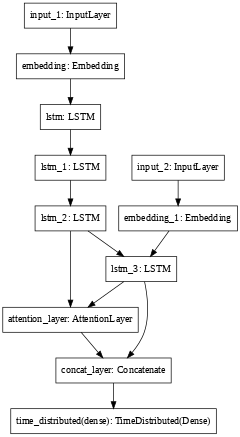

In [ ]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 162)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 162, 100)     2000200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 162, 320), ( 538880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Entrenamiento del modelo

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [ ]:
%%time


from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 50, 

                    #terminar antes cuando no disminuya la función de pérdida
                    callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                                             verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/50
34/34 [==============================] - 42s 903ms/step - loss: 4.2569 - val_loss: 2.5267
Epoch 2/50
34/34 [==============================] - 30s 888ms/step - loss: 2.4732 - val_loss: 2.4263
Epoch 3/50
34/34 [==============================] - 29s 867ms/step - loss: 2.3519 - val_loss: 2.3782
Epoch 4/50
34/34 [==============================] - 29s 868ms/step - loss: 2.2765 - val_loss: 2.3365
Epoch 5/50
34/34 [==============================] - 30s 875ms/step - loss: 2.2120 - val_loss: 2.3008
Epoch 6/50
34/34 [==============================] - 30s 874ms/step - loss: 2.1663 - val_loss: 2.2522
Epoch 7/50
34/34 [==============================] - 30s 873ms/step - loss: 2.0861 - val_loss: 2.2246
Epoch 8/50
34/34 [==============================] - 30s 877ms/step - loss: 2.0450 - val_loss: 2.2199
Epoch 9/50
34/34 [==============================] - 30s 878ms/step - loss: 1.9994 - val_loss: 2.1546
Epoch 10/50
34/34 [==============================] - 30s 876ms/step - loss: 1.9329 - val_lo

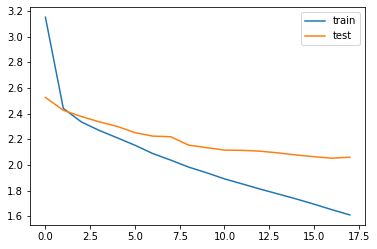

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
#Guardar todo el modelo
model.save('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM/assets


In [ ]:
#modelo = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/rrn_modelo')

# Check its architecture
#modelo.summary()

#Invertir diccionario de vocabulario
El objetivo es que a partir de indice, regrese palabras

In [ ]:
reversed_vocabulario_dic_sum = dict(map(reversed, vocabulario_dic_sum.items()))
reversed_vocabulario_dic_text = dict(map(reversed, vocabulario_dic.items()))


#Modelo de Inferencia y Generación de Texto

In [ ]:
## encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_textos), latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

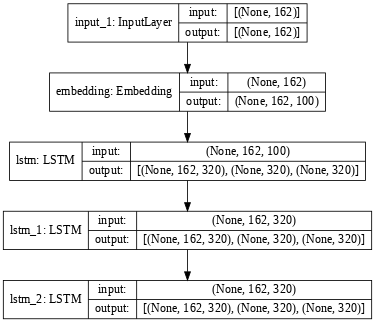

In [ ]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

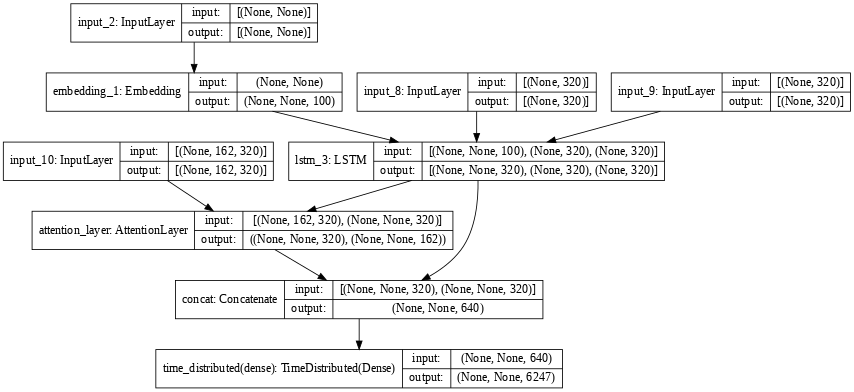

In [ ]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante decode_sequence()

[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [ ]:
reversed_vocabulario_dic_sum[0]

''

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] =  vocabulario_dic_sum['tokenstart']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reversed_vocabulario_dic_sum[sampled_token_index]

        if sampled_token!='tokenend':
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_titulos-1))):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != vocabulario_dic_sum['tokenstart']) and i != vocabulario_dic_sum['tokenend']):
        newString = newString + reversed_vocabulario_dic_sum[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reversed_vocabulario_dic_text[i]+' '
    return newString

In [ ]:
x_test_seq[1]
#.reshape(1, -1)

array([  10,   31,   21,   40,   27,   27,  363,    7, 1458,  332,   66,
          3, 1393,  113,   11, 7923,    6,   49,   44,    9,    2, 3048,
       2584,  301,   35,    2,  240,  318,  135,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
for i in range(10):
  print("Review:",seq2text(x_test_seq[i]))
  print("Original summary:",seq2summary(y_test_seq[i]))
  print("Predicted summary:",decode_sequence(x_test_seq[i].reshape(1, -1)))
  print("\n")

Review: i was so excited when bisquick came out with the gluten free version but i was frustrated with the length of time it took for me to get a hold of some i did finally order some through amazon and today i made pancakes using the mix due a milk allergy i made them with soy milk the original flavor and i added a little double strength vanilla they were fantastic and my family and guests gobbled them up i will definitely make them again and try some of the other recipes a href http www amazon com gp product b004391dk0 bisquick pancake and baking mix gluten free 16 ounce boxes pack of 3 a 
Original summary: gluten free bisquick pancakes 
Predicted summary:  great taste


Review: this coffee was just so so nothing to write home about i honestly could not distinguish it from one of the generic canister brands at the local grocery store 
Original summary: melitta cafe 
Predicted summary:  great coffee


Review: the greatest best chocolate taste in any keurig k cups out there will defini